In [1]:
from tqdm import tqdm
import numpy as np
import os
import random
import glob

import cv2
import albumentations as A

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
import segmentation_models_pytorch as smp
from torchvision.utils import make_grid, save_image
from sklearn.model_selection import train_test_split

import model
import metrics
import config
import utis

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from dataset import HistoricalImagesDataset
import config

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

# WandB – Import the wandb library
import wandb

import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

In [2]:
# Paths
IMAGES_PATH = '../data/patches/images/1942'
MASK_PATH = '../data/patches/masks/1942'
BEST_MODEL = '../best_model'
# PREDICTIONS_PATH = 

image_paths = glob.glob(IMAGES_PATH +'/*.tif')
mask_paths = glob.glob(MASK_PATH +'/*.tif')

### Weights and Biases

In [3]:
!wandb login

wandb: Currently logged in as: vibferreira (use `wandb login --relogin` to force relogin)


### Dataloader

In [4]:
# shuffle the list - COME UP WITH A SPATIAL SPLIT
X_train, X_test, y_train, y_test = train_test_split(image_paths, mask_paths, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

# Split into train, val and test
# train = int(len(image_paths)*0.7)
# val_test = int(len(image_paths)*0.15)

# train_imgs = image_paths[:train]
# val_imgs = image_paths[train+val_test:] # split of the validation and use in the test
# test_imgs = image_paths[train:train+val_test]

# train_masks = mask_paths[:train]
# val_masks = mask_paths[train+val_test:]
# test_masks = mask_paths[train:train+val_test]

# Define transformations
val_transform = A.Compose(
    [A.Normalize(mean=(0.512), std=(0.167)),
    ToTensorV2()])

train_transform = A.Compose([
      A.Rotate(limit=40,p=0.9, border_mode=cv2.BORDER_CONSTANT), # p stands for the probability with which the transformations are applied
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5), 
      A.Transpose(p=0.5),
      # A.CLAHE(p=0.8),
      A.Normalize(mean=(0.512), std=(0.167)),
      ToTensorV2()])

# Datasets
val_dataset = HistoricalImagesDataset(X_val, y_val, transform=val_transform)
train_dataset = HistoricalImagesDataset(X_train, y_train, transform=train_transform)
test_dataset = HistoricalImagesDataset(X_test, y_test, transform=val_transform)

# val_dataset = HistoricalImagesDataset(val_imgs , val_masks, transform=val_transform)
# train_dataset = HistoricalImagesDataset(train_imgs , train_masks, transform=train_transform)
# test_dataset = HistoricalImagesDataset(test_imgs , test_masks, transform=val_transform)

data = next(iter(train_dataset))
print('shape train image', data[0].shape, 'shape train mask', data[1].shape) 

# Dataloader
print("Training set size: ", len(train_dataset))
train_dataloader = DataLoader(dataset=train_dataset, batch_size = config.BATCH_SIZE, shuffle=True)
print("Validation set size: ", len(val_dataset))
val_dataloader = DataLoader(dataset=val_dataset, batch_size = config.BATCH_SIZE, shuffle=True)

print("Testing set size: ", len(test_dataset))
test_dataloader = DataLoader(dataset=test_dataset, batch_size = config.BATCH_SIZE)

shape train image torch.Size([1, 256, 256]) shape train mask torch.Size([256, 256])
Training set size:  2438
Validation set size:  523
Testing set size:  523


In [5]:
# plt.Figure()
# plt.imshow(data[0].permute(1,2,0))
# plt.imshow(data[1])

In [6]:
# # Define the transformation

# transform = A.Compose([
#       A.Rotate(limit=40,p=0.9, border_mode=cv2.BORDER_CONSTANT), # p stands for the probability with which the transformations are applied
#       A.HorizontalFlip(p=0.5),
#       A.VerticalFlip(p=0.1), 
#       A.Normalize(mean=(0), std=(1)),
#       ToTensorV2()])

# # Dataset Object 
# print('Number of image patches:', len(image_paths),'\nNumber of mask patches:', len(mask_paths))
# dataset = HistoricalImagesDataset(image_paths, mask_paths, transform=transform)
# data = next(iter(dataset))
# print('shape image', data[0].shape, 'shape mask', data[1].shape)       

# # Train, Test, Split -- DEVEOLP A SPLITTING STRATEGY BASED ON THE SPATIAL INFORMATION !!!!!!!!!
# print('Splitting data into TRAIN, VAL and TEST')
# train_size = int(0.5 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size]) #-- pytorch alternative to the train_test_split command line from Scikit-Learn

# train_size = int(0.5 * len(train_dataset))
# val_size = len(train_dataset) - train_size
# test_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# # DataLoader
# print("Training set size: ", len(train_dataset))
# train_dataloader = DataLoader(dataset=train_dataset, batch_size = config.BATCH_SIZE)
# print("Validation set size: ", len(val_dataset))
# val_dataloader = DataLoader(dataset=val_dataset, batch_size = config.BATCH_SIZE)
# print("Testing set size: ", len(test_dataset))
# test_dataloader = DataLoader(dataset=test_dataset, batch_size = config.BATCH_SIZE)

In [7]:
val_dataloader_iter = iter(val_dataloader)
# grids = utis.create_segement_grids(val_dataloader_iter)
# utis.plot_grids(grids)

In [8]:
next(val_dataloader_iter)[0].shape

torch.Size([16, 1, 256, 256])

### Check if CUDA is available

In [9]:
config.DEVICE

'cuda'

### Training

In [10]:
def train(model, dataloader, optim, lossFunc, epoch, scaler):
    # set the model in training mode
    model.train()

    # Save total train loss
    totalTrainLoss = 0
    
    # metrics
    accuracy = 0
    iou = 0
    f1score = 0
    dice = 0
    
    # loop over the training set
    loop = tqdm(dataloader, leave=False)
    for x, y in loop:
        # send the input to the device
        (x, y) = (x.to(config.DEVICE), y.float().to(config.DEVICE))
        
        # forward with autocast        
        with autocast():
            pred = model(x)
            loss = lossFunc(pred, y)
            
        optim.zero_grad()  # zero out any previously accumulated gradients    
        scaler.scale(loss).backward() # study this 
        scaler.step(optim)
        scaler.update()
        
        totalTrainLoss += loss  # add the loss to the total training loss so far 
        
        # metrics      
        all_metrics = metrics.metrics(pred, y)
        accuracy += all_metrics['acc']
        iou += all_metrics['iou']
        f1score += all_metrics['f1score']
        dice += all_metrics['dice_coeff']
        
        # update tqdm
        loop.set_description(f'Training Epoch [{epoch}/{config.NUM_EPOCHS}]')
        loop.set_postfix(loss=loss.item(), acc = all_metrics['acc'], iou=all_metrics['iou'], dice = all_metrics['dice_coeff'])
        
    # calculate the average training loss PER EPOCH
    avgTrainLoss = totalTrainLoss / len(dataloader)
    avgAccLoss = accuracy / len(dataloader)
    avgIOU = iou / len(dataloader)
    avgF1score = f1score / len(dataloader)
    avgDice = dice / len(dataloader)
    
    ## update training history
    training_history["avg_train_loss"].append(avgTrainLoss.cpu().detach().numpy()) # save the avg loss
    training_history["train_accuracy"].append(avgAccLoss) # save the acc 
    
    # WANDB
    wandb.log({
    # "Examples": example_images,
    "Train Loss": avgTrainLoss,
    "Train Accuracy": avgAccLoss,
    "IoU_train":avgIOU})
    
    return training_history

In [11]:
def validation(model, dataloader, lossFunc, epoch):
    
    # set the model in evaluation mode
    model.eval()
    # Save total train loss
    totalValLoss = 0
    
    # metrics
    accuracy_val = 0
    iou_val = 0
    f1score_val = 0
    
    # switch off autograd
    example_pred = []
    example_gt = []
    
    with torch.no_grad():
        # loop over the validation set
        loop = tqdm(dataloader, leave=False)
        
        for batch_idx, (x_val, y_val) in enumerate(loop):
            # send the input to the device
            (x_val, y_val) = (x_val.to(config.DEVICE), y_val.to(config.DEVICE))
            
            # make the predictions and calculate the validation loss
            pred_val = model(x_val)
            loss = lossFunc(pred_val, y_val)
            totalValLoss += loss
            
            # metrics      
            all_metrics = metrics.metrics(pred_val, y_val)
            accuracy_val += all_metrics['acc']
            iou_val += all_metrics['iou']
            f1score_val += all_metrics['f1score']
            
            # # Plotting Val 
            # if iter_  % 2 == 0: # plot every time iter is a multiple of 2
            # utis.plot_comparison(x_val, pred_val, y_val)
            # iter_ + 1

            # WandB – Log images in your test dataset automatically, along with predicted and true labels by passing pytorch tensors with image data into wandb.Image
            example_pred.append(wandb.Image(pred_val[0], caption=f"pred_iter_n_{batch_idx}"))
            # print(y_val.shape)
            example_gt.append(wandb.Image(y_val[0].float(), caption=f"gt_iter_n_{batch_idx}"))
            
            # update tqdm
            loop.set_description(f'Validation Epoch [{epoch}/{config.NUM_EPOCHS}]')
            loop.set_postfix(loss_val=loss.item(), acc_val = all_metrics['acc'], iou_val=all_metrics['iou'])
                        
    # calculate the average VALIDATION loss PER EPOCH
    avgValLoss = totalValLoss / len(dataloader)
    avgAccLoss = accuracy_val / len(dataloader)
    avgIOU = iou_val / len(dataloader)
    avgF1score = f1score_val / len(dataloader)

    ## update VALIDATION history
    validation_history["avg_val_loss"].append(avgValLoss.cpu().detach().numpy()) # save the avg loss
    validation_history["val_accuracy"].append(avgAccLoss) # save the acc
    validation_history["IoU_val"].append(avgIOU) # save the acc
    
    # WANDB
    wandb.log({
    "Predictions": example_pred,
    "GT": example_gt,
    "Val Accuracy": avgAccLoss,
    "Val Loss": avgValLoss,
    "IoU_val": avgIOU})
    
    return validation_history

### MAIN

In [12]:
# WandB – Initialize a new run
wandb.init(entity="vibferreira", project="master_thesis")

# classes
classes = ('no_vegetation', 'vegetation')

# Initialize model
unet = model.unet_model.to(config.DEVICE)

# initialize loss function and optimizer
lossFunc = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
opt = optim.Adam(unet.parameters(), lr=config.LR)

# initialize a dictionary to store TRAINING history (keep track on training)
training_history = {"avg_train_loss": [], "train_accuracy": [], "IoU":[],"f1score":[], "avgDice":[]}

# # initialize a dictionary to store VALIDATION history (keep track on VALIDATION)
validation_history = {"avg_val_loss": [], "val_accuracy": [], "IoU_val":[], "f1score_val":[]}

# Using log="all" log histograms of parameter values in addition to gradients
wandb.watch(unet, log="all")

# Autocasting 
scaler = GradScaler()

# initialize best accuracy
best_accuracy = 0.0
print(f'''Training the network for {config.NUM_EPOCHS} epochs, with a batch size of {config.BATCH_SIZE}''') # try with logger

# loop = tqdm(range(config.NUM_EPOCHS))
iter_ = 0
for e in range(config.NUM_EPOCHS):
    trained = train(unet, train_dataloader, opt, lossFunc, epoch=e, scaler=scaler)
    validated = validation(unet, val_dataloader, lossFunc, epoch=e)
    
    # Save best model
    if validated['IoU_val'][-1] > best_accuracy and e > 10: # maybe add a minimum number of epochs as conditions
        utis.save_best_model(unet, BEST_MODEL, validated, e)
        best_accuracy = validation_history['IoU_val'][-1]

wandb: Currently logged in as: vibferreira (use `wandb login --relogin` to force relogin)


Training the network for 2 epochs, with a batch size of 16


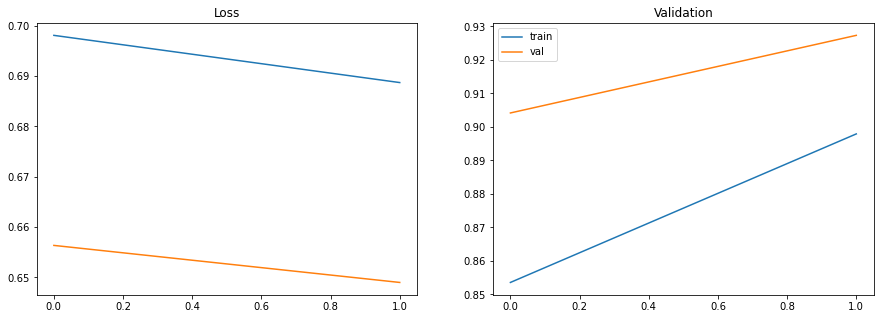

In [13]:
_, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(training_history['avg_train_loss'], label= 'train')
ax[0].plot(validation_history['avg_val_loss'], label='val')
ax[0].set_title('Loss')
ax[1].plot(training_history['train_accuracy'], label= 'train')
ax[1].plot(validation_history['val_accuracy'], label='val')
ax[1].set_title('Validation')
ax[1].legend()
plt.show()

### Predictions

In [24]:
# WandB – Initialize a new run
wandb.init(entity="vibferreira", project="master_thesis")

# set the model in evaluation mode
BEST_MODEL = '../best_model'
best_iou_model = glob.glob(BEST_MODEL + '/*.pth')[0]
folder = '../saved_images'

# load the model 
model_ = model.unet_model.to(config.DEVICE)
model_.load_state_dict(torch.load(best_iou_model))

def make_predictions():
    pass

model_.eval()

# Save total train loss
totalValLoss = 0

# log the predictions to WANDB
example_pred = []
example_gt = []

# save the predicons and the targets
y_hat_test = []
y_true_test = []

# switch off autograd
with torch.no_grad():
    # loop over the validation set
    loop = tqdm(test_dataloader, leave=False)

    for batch_idx, (x_test, y_test) in enumerate(loop):
        # send the input to the device
        (x_test, y_test) = (x_test.to(config.DEVICE), y_test.to(config.DEVICE))

        # make the predictions and calculate the validation loss
        pred_test = model_(x_test)
        loss = lossFunc(pred_test, y_test)
        totalTestLoss += loss

        # # Plotting Val 
        # utis.plot_comparison(x_test, pred_test, y_test)
        
        # Storing predictions and true labels 
        y_hat_test.append(pred_test)
        y_true_test.append(y_test)
        
        # # WandB – Log images in your test dataset automatically, along with predicted and true labels by passing pytorch tensors with image data into wandb.Image
        example_pred.append(wandb.Image(pred_test[0], caption=f"pred_iter_n_{batch_idx}"))
        example_gt.append(wandb.Image(y_test[0].float(), caption=f"gt_iter_n_{batch_idx}"))

        # update tqdm
        loop.set_description(f'Testing Epoch')

        # # WANDB
        wandb.log({
        "Predictions": example_pred,
        "GT": example_gt})

    

IoU_train,▁█
IoU_val,▁█
Train Accuracy,▁█
Train Loss,█▁
Val Accuracy,▁█
Val Loss,█▁
IoU_train,0.59191
IoU_val,0.69906
Train Accuracy,0.89791
Train Loss,0.68871
Val Accuracy,0.92732


  0%|                                                                             | 0/33 [00:00<?, ?it/s]

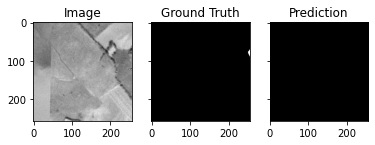

  3%|██                                                                   | 1/33 [00:00<00:24,  1.30it/s]

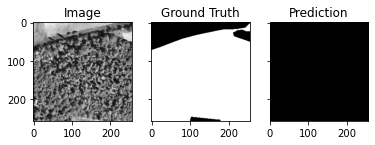

  6%|████▏                                                                | 2/33 [00:01<00:28,  1.08it/s]

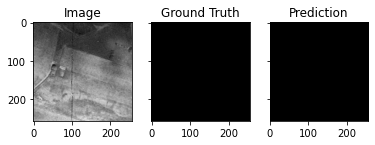

  9%|██████▎                                                              | 3/33 [00:02<00:26,  1.11it/s]

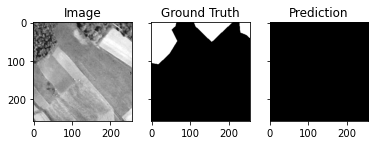

 12%|████████▎                                                            | 4/33 [00:03<00:24,  1.16it/s]

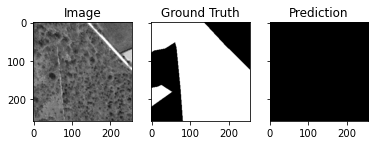

 15%|██████████▍                                                          | 5/33 [00:04<00:22,  1.23it/s]

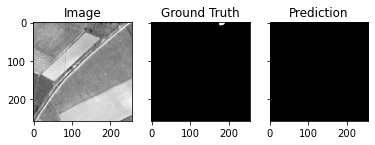

 18%|████████████▌                                                        | 6/33 [00:04<00:21,  1.26it/s]

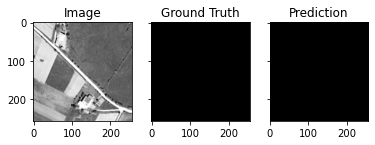

 21%|██████████████▋                                                      | 7/33 [00:05<00:20,  1.27it/s]

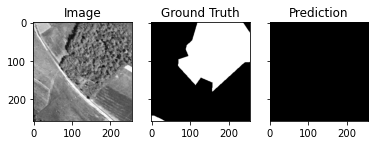

 24%|████████████████▋                                                    | 8/33 [00:06<00:20,  1.24it/s]

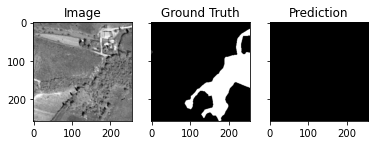

 27%|██████████████████▊                                                  | 9/33 [00:07<00:18,  1.29it/s]

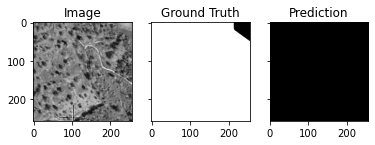

 30%|████████████████████▌                                               | 10/33 [00:07<00:16,  1.35it/s]

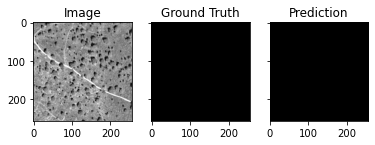

 33%|██████████████████████▋                                             | 11/33 [00:08<00:16,  1.34it/s]

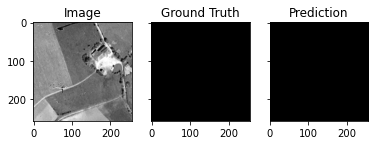

 36%|████████████████████████▋                                           | 12/33 [00:09<00:14,  1.41it/s]

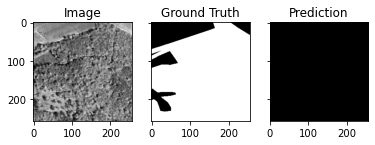

 39%|██████████████████████████▊                                         | 13/33 [00:09<00:13,  1.50it/s]

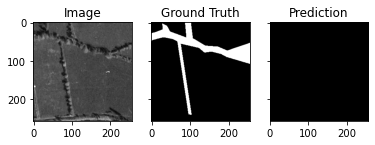

 42%|████████████████████████████▊                                       | 14/33 [00:10<00:12,  1.47it/s]

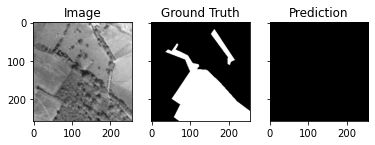

 45%|██████████████████████████████▉                                     | 15/33 [00:11<00:11,  1.59it/s]

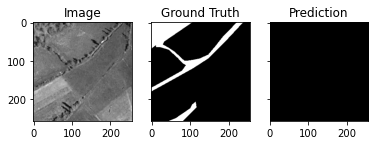

 48%|████████████████████████████████▉                                   | 16/33 [00:11<00:10,  1.61it/s]

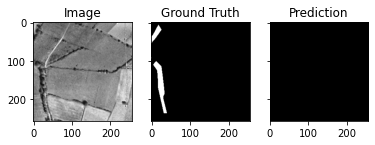

 52%|███████████████████████████████████                                 | 17/33 [00:12<00:09,  1.66it/s]

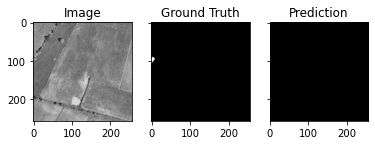

 55%|█████████████████████████████████████                               | 18/33 [00:12<00:08,  1.71it/s]

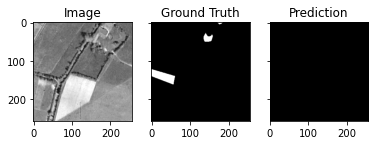

 58%|███████████████████████████████████████▏                            | 19/33 [00:13<00:07,  1.79it/s]

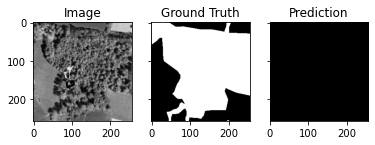

 61%|█████████████████████████████████████████▏                          | 20/33 [00:14<00:08,  1.54it/s]

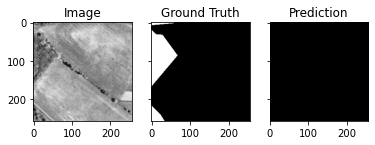

 64%|███████████████████████████████████████████▎                        | 21/33 [00:14<00:08,  1.49it/s]

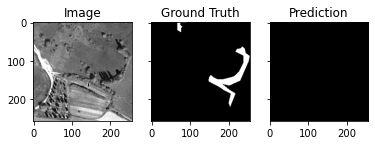

 67%|█████████████████████████████████████████████▎                      | 22/33 [00:15<00:07,  1.50it/s]

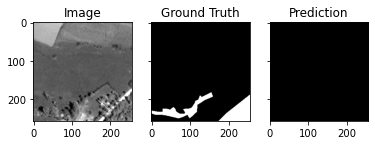

 70%|███████████████████████████████████████████████▍                    | 23/33 [00:16<00:06,  1.47it/s]

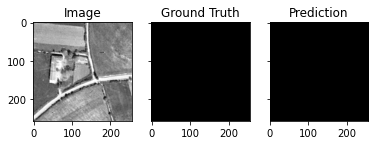

 73%|█████████████████████████████████████████████████▍                  | 24/33 [00:17<00:06,  1.44it/s]

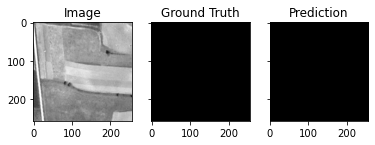

 76%|███████████████████████████████████████████████████▌                | 25/33 [00:17<00:05,  1.51it/s]

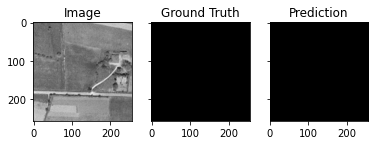

 79%|█████████████████████████████████████████████████████▌              | 26/33 [00:18<00:04,  1.48it/s]

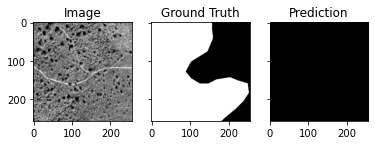

 82%|███████████████████████████████████████████████████████▋            | 27/33 [00:18<00:03,  1.56it/s]

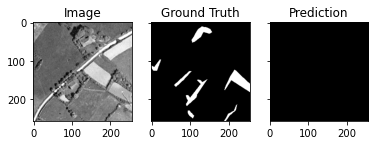

 85%|█████████████████████████████████████████████████████████▋          | 28/33 [00:19<00:03,  1.63it/s]

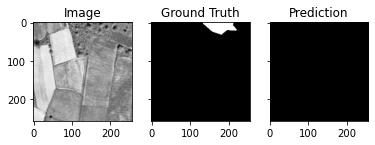

 88%|███████████████████████████████████████████████████████████▊        | 29/33 [00:20<00:02,  1.52it/s]

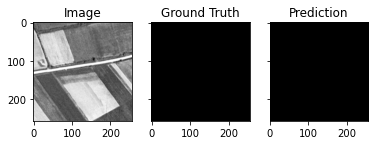

 91%|█████████████████████████████████████████████████████████████▊      | 30/33 [00:20<00:01,  1.54it/s]

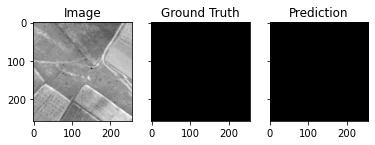

 94%|███████████████████████████████████████████████████████████████▉    | 31/33 [00:21<00:01,  1.58it/s]

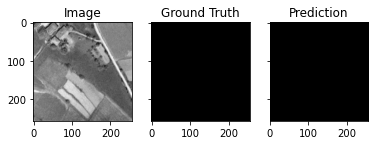

 97%|█████████████████████████████████████████████████████████████████▉  | 32/33 [00:21<00:00,  1.63it/s]

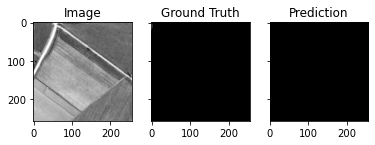

In [14]:
def make_predictions():   # test dataloader
    pass

# path to best model 
BEST_MODEL = '../best_model'
best_iou_model = glob.glob(BEST_MODEL + '/*.pth')[0]
folder = '../saved_images' 

# load the model 
unet_pred = model.unet_model.to(config.DEVICE)
unet_pred.load_state_dict(torch.load(best_iou_model))

y_hat_test = []
y_true_test = []

# Save total test loss
totalTestLoss = 0

# metrics
accuracy_test = 0
iou_test = 0
f1score_test = 0

# switch off autograd
example_pred = []
example_gt = []

# switch off autograd
with torch.no_grad():
    # set the model in evaluation mode
    unet_pred.eval()

    # loop over the validation set
    loop = tqdm(test_dataloader, leave=False)

    for idx, (x_test, y_test) in enumerate(loop):
        # send the input to the device
        (x_test, y_test)  = (x_test.to(config.DEVICE), y_test.to(config.DEVICE))

        # Predictions
        pred_test = unet_pred(x_test)

        # Assign appropriate class 
        pred_test = pred_test.sigmoid()
        pred_test = (pred_test > 0.5).float()

        # Storing predictions and true labels 
        y_hat_test.append(pred_test)
        y_true_test.append(y_test)

        # metrics
        all_metrics = metrics.metrics(pred_test, y_test)
        accuracy_test += all_metrics['acc']
        iou_test += all_metrics['iou']
        f1score_test += all_metrics['f1score']
        
        # plots
        utis.plot_comparison(x_test, pred_test, y_test)
        
        # WandB – Log images in your test dataset automatically, along with predicted and true labels by passing pytorch tensors with image data into wandb.Image
        example_pred.append(wandb.Image(pred_test[0], caption=f"pred_iter_n_{idx}"))
        example_gt.append(wandb.Image(y_test[0].float(), caption=f"gt_iter_n_{idx}"))
        
    # # WANDB
    # wandb.log({
    # # "Predictions": example_pred,
    # # "GT": example_gt,
    # "Test Accuracy": accuracy_test / len(test_dataloader),
    # "IoU_test": f1score_test / len(test_dataloader)})
    

        # Save images
        # save_image(pred_test, f"{folder}/pred_{idx}.png") 
        # save_image(y_test, f"{folder}/y_true_{idx}.png")

# # Stack and flatten for confusion matrix # GETTING SIZE ERROR AT THE MOMENT
# torch.stack(y_hat_test).flatten()
# torch.stack(y_true_test).flatten()

In [15]:
# y_hat_test[0].detach().cpu()